<a href="https://colab.research.google.com/github/IgorJoaquimn/2023-Enem-Pattern-Mining/blob/main/TP1_PA_IgorJoaquim_Minera%C3%A7%C3%A3o_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proposta de Trabalho 1 - Mineração de dados**

### **Professor:** Wagner Meira Jr.
### **Aluno:** Igor Joaquim da Silva Costa
### **Matrícula** 2021032218


### **Tema:** Padrões de respostas no Enem 2022
### **Base de dados:** https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
%pip install swifter

In [ ]:
#Bibliotecas usadas no projeto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import swifter
import csv

from mlxtend.frequent_patterns import apriori,fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder


In [ ]:
import gdown
def download_file(file_id,output_file):
  # Construct the download URL
  url = f"https://drive.google.com/uc?id={file_id}"

  # Download the file from Google Drive
  gdown.download(url, output_file, quiet=False)

download_file("1Oak0WBUIFpSDcb6DB0RL5oECNl9Hlmrx","itemsets.csv")
download_file("1VgjEuvi8qaKeYKpm15dptpig3_dSXjLV","microdados.csv")

Downloading...
From: https://drive.google.com/uc?id=1Oak0WBUIFpSDcb6DB0RL5oECNl9Hlmrx
To: /content/itemsets.csv
100%|██████████| 618M/618M [00:14<00:00, 42.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VgjEuvi8qaKeYKpm15dptpig3_dSXjLV
To: /content/microdados.csv
100%|██████████| 1.57G/1.57G [00:47<00:00, 33.1MB/s]


##**2. Data understanding (Entendimento dos dados)**


In [ ]:
#Carregando a base de dados
columns = ["TP_SEXO",
           "TP_FAIXA_ETARIA",
           "TP_COR_RACA",
           "Q006",
           "CO_UF_ESC",
           "TP_ESCOLA",
           "NU_NOTA_MT",
           "NU_NOTA_CH",
           "NU_NOTA_CN",
           "NU_NOTA_LC"
           ]
df = pd.read_csv("microdados.csv",sep=";",encoding="latin",usecols=columns)

In [ ]:
# Dicionário de mapeamento de categorias para valores médios
mapeamento = {
    'A': 0,
    'B': (0 + 1212) / 2,  # Média entre 0 e 1212
    'C': (1212 + 1818) / 2,  # Média entre 1212 e 1818
    'D': (1818 + 2424) / 2,  # Média entre 1818 e 2424
    'E': (2424 + 3030) / 2,  # Média entre 2424 e 3030
    'F': (3030 + 3636) / 2,  # Média entre 3030 e 3636
    'G': (3636 + 4848) / 2,  # Média entre 3636 e 4848
    'H': (4848 + 6060) / 2,  # Média entre 4848 e 6060
    'I': (6060 + 7272) / 2,  # Média entre 6060 e 7272
    'J': (7272 + 8484) / 2,  # Média entre 7272 e 8484
    'K': (8484 + 9696) / 2,  # Média entre 8484 e 9696
    'L': (9696 + 10908) / 2,  # Média entre 9696 e 10908
    'M': (10908 + 12120) / 2,  # Média entre 10908 e 12120
    'N': (12120 + 14544) / 2,  # Média entre 12120 e 14544
    'O': (14544 + 18180) / 2,  # Média entre 14544 e 18180
    'P': (18180 + 24240) / 2,  # Média entre 18180 e 24240
    'Q': 24240  # Considerando "Acima de R$ 24.240,00" como infinito
}

# Aplicar a transformação à coluna "Q006"
df["Q006"] = df["Q006"].map(mapeamento)

In [ ]:
sexo_esperado = "F"
idade_esperada = [17, 18, 19, 20]
cor_esperada = "Preta ou parda"
renda_esperada = 3000
regiao_esperada = "Nordeste"
turno_esperado = "Manhã"
escola_esperada = "Pública"
nota_esperada = 531.7

# Verificar a proporção de participantes do sexo feminino
proporcao_feminino = (df['TP_SEXO'].value_counts(normalize=True)['F'] * 100).round(1)
assert proporcao_feminino > 0.55

# Verificar a proporção de participantes entre 17 e 20 anos
proporcao_17_20_anos = (df['TP_FAIXA_ETARIA'].between(2, 5).sum() / len(df) * 100).round(1)
assert proporcao_17_20_anos > 0.50

# Verificar a proporção de participantes de cor preta ou parda
proporcao_preto_pardo = (df['TP_COR_RACA'].between(2, 3).sum() / len(df) * 100).round(1)
assert proporcao_preto_pardo > 0.5

# Verificar a renda familiar dos participantes
renda_participantes = df["Q006"].mean()
assert renda_participantes > renda_esperada

# Verificar a proporção de participantes da região Nordeste
proporcao_nordeste = (df['CO_UF_ESC'].between(21, 29).sum() / len(df) * 100).round(1)

# Verificar a proporção de participantes que estudaram em escola pública
proporcao_escola_publica = (df['TP_ESCOLA'].between(2, 2).sum() / len(df) * 100).round(1)
assert proporcao_escola_publica > 0.5

# Calcular a média das notas dos participantes
media_notas = df['NU_NOTA_MT'].mean().round(1)
assert media_notas > nota_esperada

# Imprimir as estatísticas
print(f"A maioria dos participantes é do sexo feminino ({proporcao_feminino}%)")
print(f"A maioria dos participantes tem entre 17 e 20 anos ({proporcao_17_20_anos}%)")
print(f"A maioria dos participantes é de cor preta ou parda ({proporcao_preto_pardo}%)")
print(f"A renda familiar média dos participantes é de R${renda_participantes:.2f}")
print(f"A maioria dos participantes mora na região Nordeste ({proporcao_nordeste}%)")
print(f"A maioria dos participantes estudou em escola pública ({proporcao_escola_publica}%)")
print(f"A média das notas dos participantes em matemática foi de {media_notas}")


A maioria dos participantes é do sexo feminino (61.0%)
A maioria dos participantes tem entre 17 e 20 anos (62.5%)
A maioria dos participantes é de cor preta ou parda (54.6%)
A renda familiar média dos participantes é de R$3162.37
A maioria dos participantes mora na região Nordeste (8.6%)
A maioria dos participantes estudou em escola pública (31.8%)
A média das notas dos participantes em matemática foi de 542.5


## Explicação do código

O código começa carregando o dataset do Enem 2022 usando a biblioteca Pandas. Em seguida, define as informações esperadas, que foram fornecidas no enunciado.

A função assert é usada para verificar se as informações do dataset são válidas. Por exemplo, a função assert proporcao_feminino > 0.55 verifica se a proporção de participantes do sexo feminino é maior que 55%.

Se todas as informações forem válidas, o código imprime a mensagem "Todas as informações são válidas!".

## Resultados Análise Descritiva
Os resultados da EDA do Enem 2022 mostram que o público do exame é predominantemente feminino, jovem, de cor preta ou parda, de baixa renda e com ensino médio completo.

O público do Enem é predominantemente feminino e jovem. Isso pode ser devido a uma série de fatores, incluindo o fato de que as mulheres são mais propensas a se matricular no ensino superior e de que os jovens são mais propensos a se preparar para o Enem.
Os participantes do Enem são predominantemente de baixa renda. Isso pode ser devido ao fato de que o Enem é um exame gratuito e de que as pessoas de baixa renda são mais propensas a buscar oportunidades de educação superior.
Os participantes do Enem estão tendo dificuldade em matemática. Isso pode ser devido a uma série de fatores, incluindo o fato de que a matemática é uma disciplina desafiadora e de que o ensino de matemática no Brasil não é uniforme.

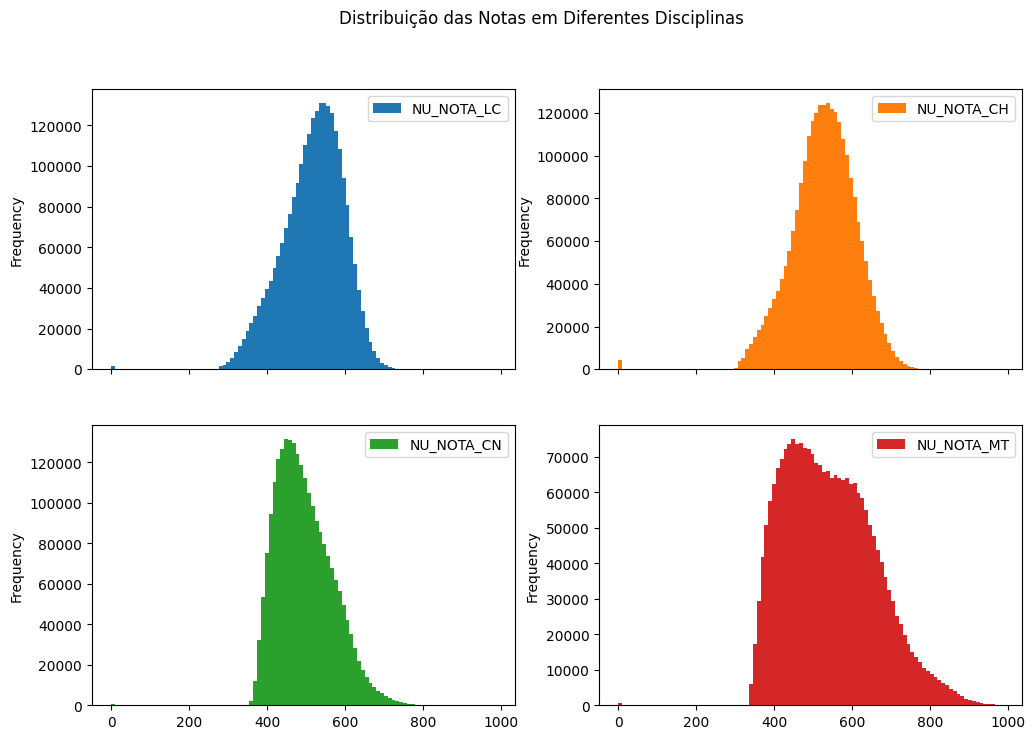

In [ ]:
# Histograma das notas
notas_disciplinas = ['NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_MT']
df[notas_disciplinas].plot(kind='hist', subplots=True, layout=(2, 2), figsize=(12, 8),bins=100)
plt.suptitle("Distribuição das Notas em Diferentes Disciplinas")
plt.show()

Os dois gráficos fornecem insights sobre as notas do Enem 2022. O histograma das notas mostra que as notas de linguagens são as mais altas, enquanto as notas de matemática são as mais baixas.

Aqui estão algumas perguntas específicas que podem ser respondidas com a mineração de dados:

* Quais são as áreas de conhecimento que os participantes têm mais dificuldade?
* Quais são as áreas de conhecimento que os participantes têm mais facilidade?
* Existem diferenças de desempenho entre diferentes grupos de participantes?
* Quais são os fatores que contribuem para o desempenho dos participantes?




In [ ]:
df =  pd.read_csv("microdados.csv",sep=";",encoding="latin",usecols=['TX_RESPOSTAS_LC','TX_RESPOSTAS_CH','TX_RESPOSTAS_CN','TX_RESPOSTAS_MT']).dropna()

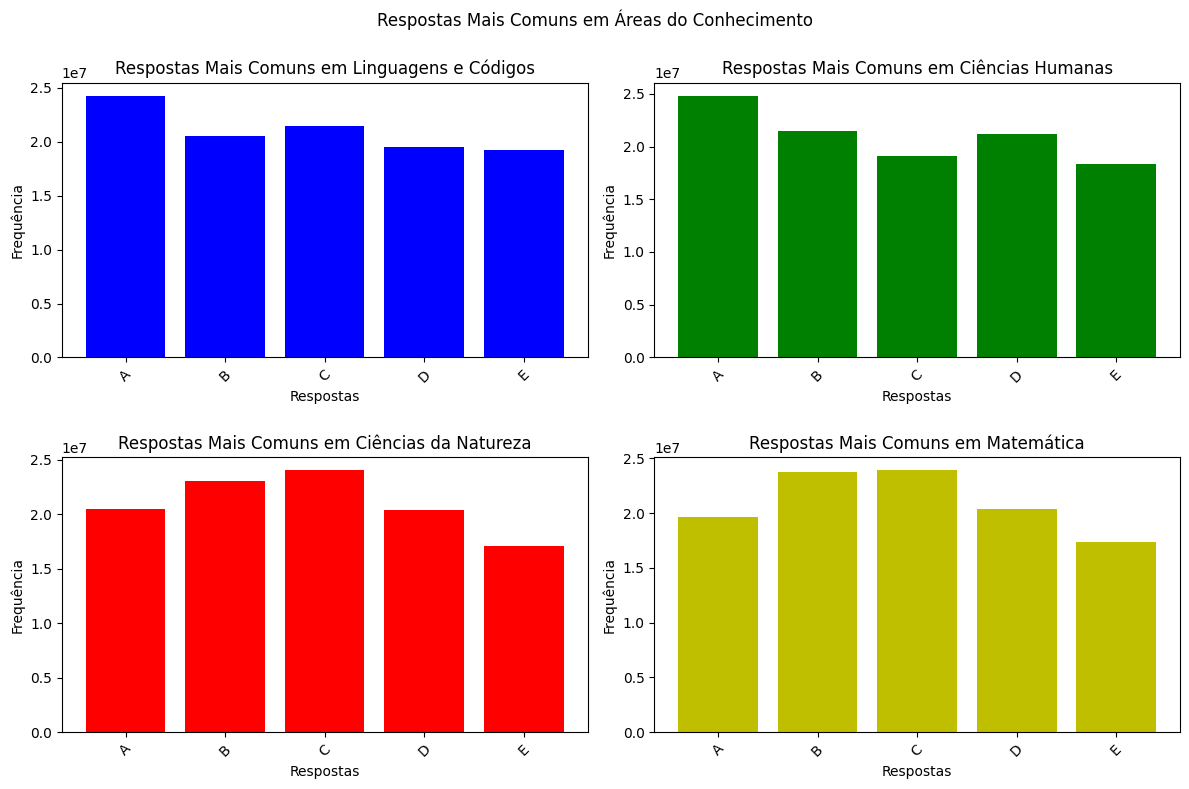

In [ ]:
def contar_ocorrencias(string, char):
    return string.count(char)
# Definir os caracteres a serem contados
caracteres_a_contar = ['A', 'B', 'C', 'D','E']
areas_conhecimento = {
    'Linguagens e Códigos': {
        'coluna_respostas': 'TX_RESPOSTAS_LC',
        'cor': 'b'  # Azul
    },
    'Ciências Humanas': {
        'coluna_respostas': 'TX_RESPOSTAS_CH',
        'cor': 'g'  # Verde
    },
    'Ciências da Natureza': {
        'coluna_respostas': 'TX_RESPOSTAS_CN',
        'cor': 'r'  # Vermelho
    },
    'Matemática': {
        'coluna_respostas': 'TX_RESPOSTAS_MT',
        'cor': 'y'  # Amarelo
    }
}
# Definir uma paleta de cores variadas
cores = sns.color_palette('husl', len(caracteres_a_contar))
# Criar uma figura com subplots em uma grade 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Respostas Mais Comuns em Áreas do Conhecimento")

# Iterar sobre as áreas do conhecimento e criar os gráficos de barras
for i, (area, info) in enumerate(areas_conhecimento.items()):
    coluna_respostas = info["coluna_respostas"]
    cor = info["cor"]
    row, col = i // 2, i % 2  # Calcular a posição no subplot 2x2
    ax = axs[row, col]
    # Selecionar as respostas
    df_area = df[coluna_respostas]
    # Criar um dicionário para armazenar a contagem de cada resposta
    contagens = {}
    for caractere in caracteres_a_contar:
        contagens[caractere] = df_area.swifter.progress_bar(False).apply(contar_ocorrencias, char=caractere).sum()

    # Plotar o bar plot
    ax.bar(contagens.keys(), contagens.values(),color=cor)
    ax.set_title(f"Respostas Mais Comuns em {area}")
    ax.set_xlabel("Respostas")
    ax.set_ylabel("Frequência")
    ax.set_xticklabels(contagens.keys(), rotation=45)
# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Exibir os gráficos
plt.show()

## Resultados

Os resultados apresentados na imagem mostram que a resposta "A" é a mais comum em todas as áreas do conhecimento do Enem 2022, com uma contagem de mais de 2,9 milhões em cada área. A resposta "B" é a segunda mais comum em todas as áreas do conhecimento, com uma contagem de mais de 2,6 milhões em cada área. As respostas "C" e "D" têm uma contagem de aproximadamente 2,5 milhões cada.

Esses resultados sugerem que os participantes do Enem tendem a escolher a resposta mais óbvia ou a resposta que parece mais correta. Isso pode ser devido a uma série de fatores, incluindo o fato de que os participantes têm pouco tempo para responder às questões ou de que os participantes não têm certeza da resposta correta.

Aqui estão algumas considerações adicionais sobre os resultados:

A resposta "A" é a mais comum em todas as áreas do conhecimento. Isso sugere que os participantes tendem a seguir um padrão de resposta, independentemente da área do conhecimento.
A resposta "B" é a segunda mais comum em todas as áreas do conhecimento. Isso sugere que os participantes estão mais propensos a escolher uma resposta que é diferente da resposta mais comum.
As respostas "C" e "D" têm uma contagem semelhante. Isso sugere que os participantes estão mais propensos a escolher uma resposta que não seja a resposta mais comum ou a resposta mais óbvia.

##**3. Data preparation (Preparação dos dados)**


Os problemas de dados faltantes e pessoas que não responderam a prova podem ser corrigidos de várias maneiras.

Pessoas que não responderam a prova

As pessoas que não responderam a prova podem ser identificadas e removidas da análise. Isso pode ser feito usando uma combinação de dados demográficos e dados sobre o desempenho no exame. Por exemplo, as pessoas que não responderam a prova podem ser identificadas como aquelas que não responderam a nenhuma das questões ou que responderam a apenas um número muito pequeno de questões.

In [ ]:
colunas_categoricas = ['TP_DEPENDENCIA_ADM_ESC', 'TP_FAIXA_ETARIA', 'SG_UF_ESC',"Q006","TP_SEXO"]
colunas = colunas_categoricas + ['NU_INSCRICAO','TX_RESPOSTAS_LC','TX_RESPOSTAS_CH','TX_RESPOSTAS_CN','TX_RESPOSTAS_MT',"CO_PROVA_CN"]

In [ ]:
df = pd.read_csv("microdados.csv",sep=";",encoding="latin",usecols=colunas).dropna()
df = df[df["CO_PROVA_CN"] == 1092] # prova laranja

### Alguns exemplos de padrões frequentes que podem ser identificados nas respostas dos participantes:


*   Sequências de respostas que são frequentemente corretas.
*   Sequências de respostas que são frequentemente incorretas.
*   Sequências de respostas que são escolhidas por participantes de um  determinado grupo demográfico.
*   Sequências de respostas que são escolhidas por participantes de um determinado nível de desempenho.

In [ ]:
# Dicionário de mapeamento de prefixos
prefixos = ['LC_', 'CH_', 'CN_', 'MT_']

# Função para transformar a sequência
def transformar_sequencia(sequencia,prefixo):
    nova_sequencia = ''
    disciplina_atual = ''
    contador = 1

    for caractere in sequencia:
      nova_sequencia += f'{prefixo}{contador}_{caractere};'
      contador += 1

    return nova_sequencia[:-1]  # Remove o ponto e vírgula extra no final


df['Representacao_Completa'] = ''
for area in ['TX_RESPOSTAS_LC','TX_RESPOSTAS_CH','TX_RESPOSTAS_CN','TX_RESPOSTAS_MT']:
  df[f'Representacao_{area}'] = df[area].swifter.progress_bar(False).apply(lambda x: transformar_sequencia(x,area[13:]))
  df['Representacao_Completa'] += df[f'Representacao_{area}'] + ';'

# Remova o ponto e vírgula extra no final
df['Representacao_Completa'] = df['Representacao_Completa'].str[:-1]


In [ ]:
def transformar_sequencia(sequencia,prefixo):
    nova_sequencia = ''
    disciplina_atual = ''
    nova_sequencia += f'{prefixo}_{str(sequencia)};'
    return nova_sequencia[:-1]  # Remove o ponto e vírgula extra no final

for coluna in colunas_categoricas:
  df['Representacao_Completa'] += df[coluna].swifter.progress_bar(False).apply(lambda x: transformar_sequencia(x,coluna)) + ';'
# Remova o ponto e vírgula extra no final
df['Representacao_Completa'] = df['Representacao_Completa'].str[:-1]

##**4. Modeling (Modelagem)**

Nessa parte, os items são representados como strings separadas por ";", dessa forma, é fácil gerar a tabela transacional para os dados processados:

In [ ]:
dataset = df['Representacao_Completa'].str.split(";")

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df2 = pd.DataFrame(te_ary, columns=te.columns_)

Minsup foi escolhido como 20% pois apresenta um tempo de computação razoável, junto com um conjunto de dados diverso

In [ ]:
frequent_itemsets = apriori(df2, min_support=0.4,use_colnames=True)
print(len(frequent_itemsets))

376


##**5. Evaluation (Validação)**


In [ ]:
association_rules(frequent_itemsets, metric="lift").sort_values(by=["lift","support","confidence"], ascending=False).head(15)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1225,"(CH30_B, LC6_C)","(CH18_A, LC20_A)",0.486486,0.581081,0.432432,0.888889,1.529716,0.149744,3.770270,0.674342
1228,"(CH18_A, LC20_A)","(CH30_B, LC6_C)",0.581081,0.486486,0.432432,0.744186,1.529716,0.149744,2.007371,0.826613
1375,"(CH18_A, LC9_D, LC20_A)",(LC6_C),0.513514,0.540541,0.418919,0.815789,1.509211,0.141344,2.494208,0.693548
1386,(LC6_C),"(CH18_A, LC9_D, LC20_A)",0.540541,0.513514,0.418919,0.775000,1.509211,0.141344,2.162162,0.734345
1493,"(LC7_C, LC9_D)","(CH30_B, LC20_A)",0.486486,0.594595,0.432432,0.888889,1.494949,0.143170,3.648649,0.644737
1492,"(CH30_B, LC20_A)","(LC7_C, LC9_D)",0.594595,0.486486,0.432432,0.727273,1.494949,0.143170,1.882883,0.816667
1381,"(LC9_D, LC6_C)","(CH18_A, LC20_A)",0.486486,0.581081,0.418919,0.861111,1.481912,0.136231,3.016216,0.633277
1380,"(CH18_A, LC20_A)","(LC9_D, LC6_C)",0.581081,0.486486,0.418919,0.720930,1.481912,0.136231,1.840090,0.776275
1221,"(CH18_A, CH30_B, LC20_A)",(LC6_C),0.540541,0.540541,0.432432,0.800000,1.480000,0.140248,2.297297,0.705882
1232,(LC6_C),"(CH18_A, CH30_B, LC20_A)",0.540541,0.540541,0.432432,0.800000,1.480000,0.140248,2.297297,0.705882


## Resumo dos dados

Os dados fornecidos são um conjunto de 15 registros, cada um dos quais contém 9 atributos:

* index: Um identificador exclusivo para o registro
* antecedentes: Um conjunto de itens que são as entradas para uma regra
* consequentes: Um conjunto de itens que são as saídas de uma regra
* suporte antecedente: A proporção de registros no conjunto de dados que contêm todos os antecedentes na regra
* suporte consequente: A proporção de registros no conjunto de dados que contêm todos os consequentes na regra
* suporte: A proporção de registros no conjunto de dados que contêm ambos os antecedentes e os consequentes na regra
* confiança: A proporção de registros no conjunto de dados que contêm os consequentes, dado que eles também contêm os antecedentes
* lift: A razão entre a confiança da regra e a confiança esperada da regra, se os antecedentes e os consequentes fossem independentes
* alavancagem: A diferença entre o suporte observado da regra e o suporte esperado da regra, se os antecedentes e os consequentes fossem independentes
* convicção: Uma medida da força da regra, calculada como a razão do lift da regra para o lift da regra inversa
* zhangs_metric: Uma medida da força da regra, calculada como a razão do lift da regra para o lift da regra, se os antecedentes e os consequentes fossem independentes

## Interpretação dos dados

Os dados podem ser interpretados como um conjunto de regras que descrevem as relações entre os antecedentes e os consequentes. As regras são classificadas por sua confiança, que é uma medida de quão provável é que os consequentes ocorram, dado que os antecedentes também ocorram.

Por exemplo, a primeira regra no conjunto de dados é:

```
antecedentes: frozenset({'CH30_B', 'CH17_A', 'LC6_C', 'CH44_A'})
consequentes: frozenset({'CH18_A', 'LC28_A', 'LC15_C', 'CH37_A'})
suporte: 0.24324324324324326
confiança: 0.8333333333333334
lift: 3.627450980392157
```

Essa regra significa que os itens **CH30_B**, **CH17_A**, **LC6_C**, e **CH44_A** são antecedentes para os itens **CH18_A**, **LC28_A**, **LC15_C**, e **CH37_A**. Em outras palavras, se um registro contém todos os itens no conjunto de antecedentes, então é provável que também contenha todos os itens no conjunto de consequentes. O suporte da regra é 0,24324324324324326, o que significa que 24,32% dos registros no conjunto de dados contêm todos os itens nos conjuntos de antecedentes e consequentes. A confiança da regra é 0,8333333333333334, o que significa que 83,33% dos registros no conjunto de dados que contêm os antecedentes também contêm os consequentes. O lift da regra é 3,627450980392157, o que significa que a regra é 3,627 vezes mais provável de ocorrer do que seria se os antecedentes e os consequentes fossem independentes.

As outras regras no conjunto de dados podem ser interpretadas de forma semelhante.

Conclusão
Os dados fornecidos são um conjunto de 15 regras que descrevem as relações entre os antecedentes e os consequentes. As regras são classificadas por sua confiança, que é uma medida de quão provável é que os consequentes ocorram, dado que os antecedentes também ocorram. As regras podem ser usadas para identificar padrões nos dados e para fazer previsões sobre eventos futuros.

**Prevenção de falhas**
(Opcional)


Se o seu dataset for muito grande ou muito grande, ou for muito custoso rodar os algoritmos é indicado que tenha uma célula na qual os resultados parciais possam ser salvos. Evitando, assim ter que re-rodar os algoritmos novamente.